학습은 kaggle에 미리 받아놓은 데이터셋을 다운로드 받아서 colab에서 진행했습니다.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("geon05/dataset2")
path2 = kagglehub.dataset_download("geon05/damages-masks")

print("Path to dataset files:", path)
print("Path to dataset files:", path2)

100%|██████████| 17.7G/17.7G [01:55<00:00, 165MB/s]

Extracting files...


100%|██████████| 13.9G/13.9G [01:32<00:00, 162MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/geon05/dataset2/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1


이전 모델 가중치를 찾지 못했습니다. 처음부터 학습을 시작합니다.


Epoch [1/50]: 100%|██████████| 5921/5921 [1:26:09<00:00,  1.15it/s]

Epoch [1/50] - G Loss: 20.3087, D Loss: 0.4853


Validation L1 Loss: 0.0872


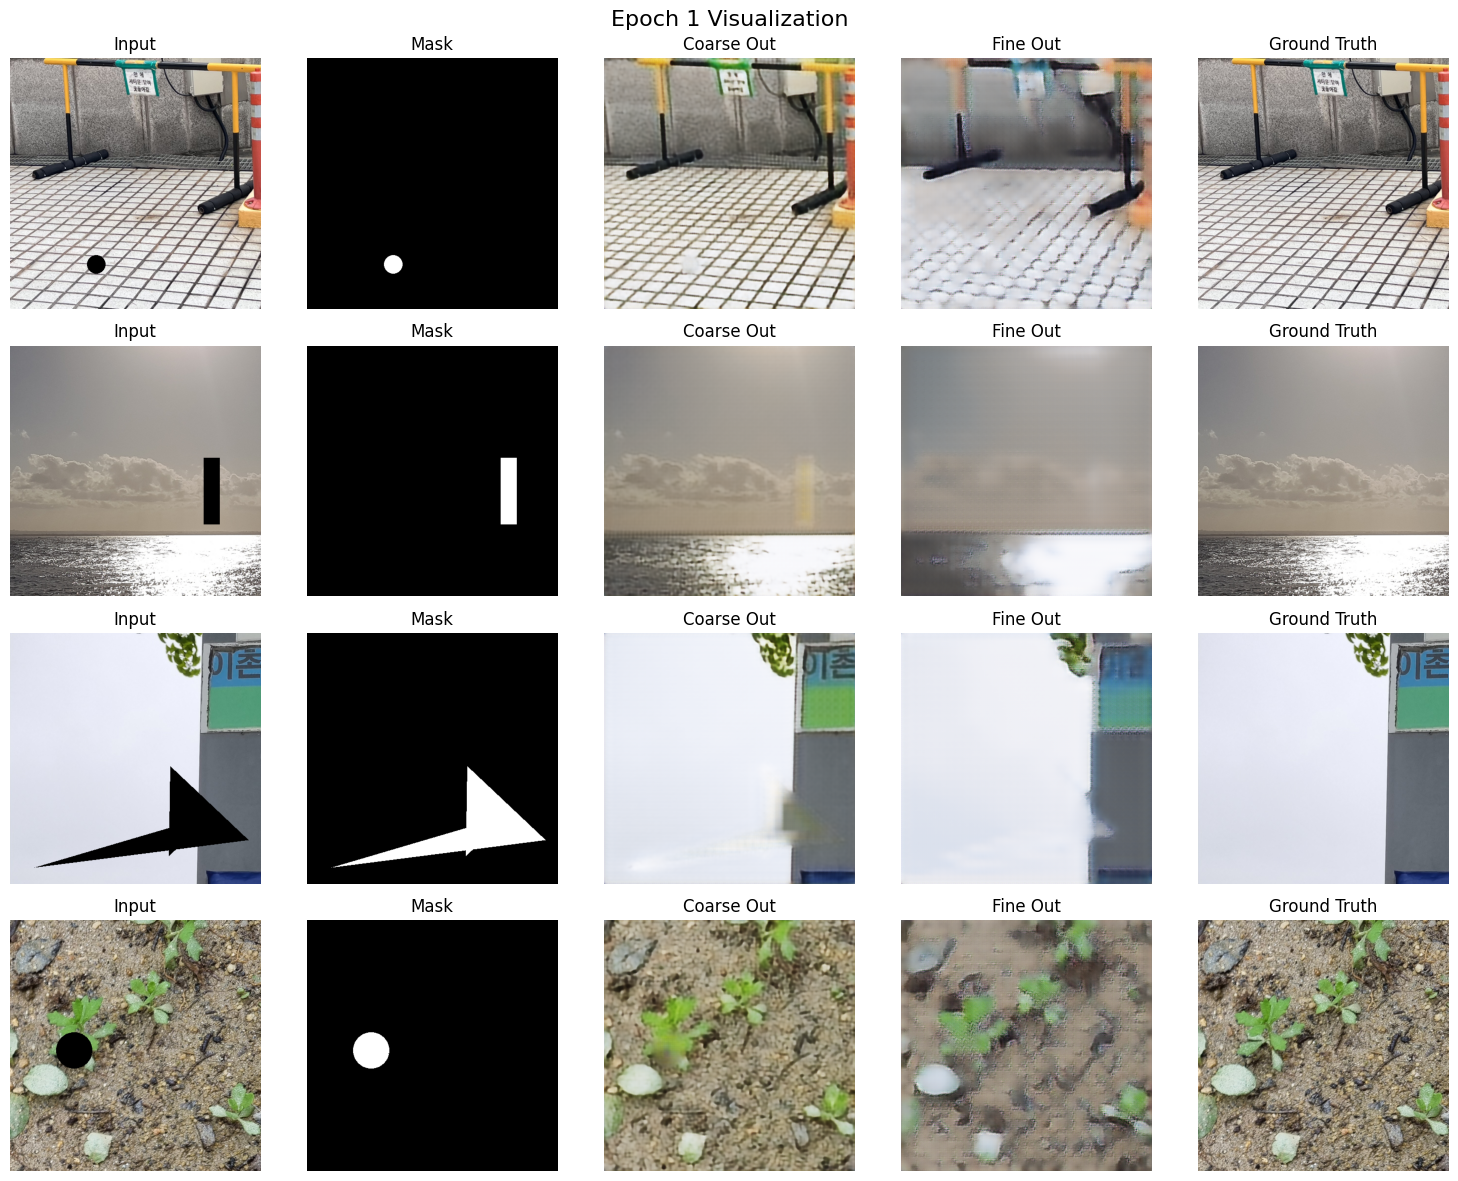

최적 모델 갱신! Validation L1 Loss: 0.0872, 모델 저장 완료.


Epoch [2/50]: 100%|██████████| 5921/5921 [1:26:19<00:00,  1.14it/s]

Epoch [2/50] - G Loss: 14.3936, D Loss: 0.5290


Validation L1 Loss: 0.0610


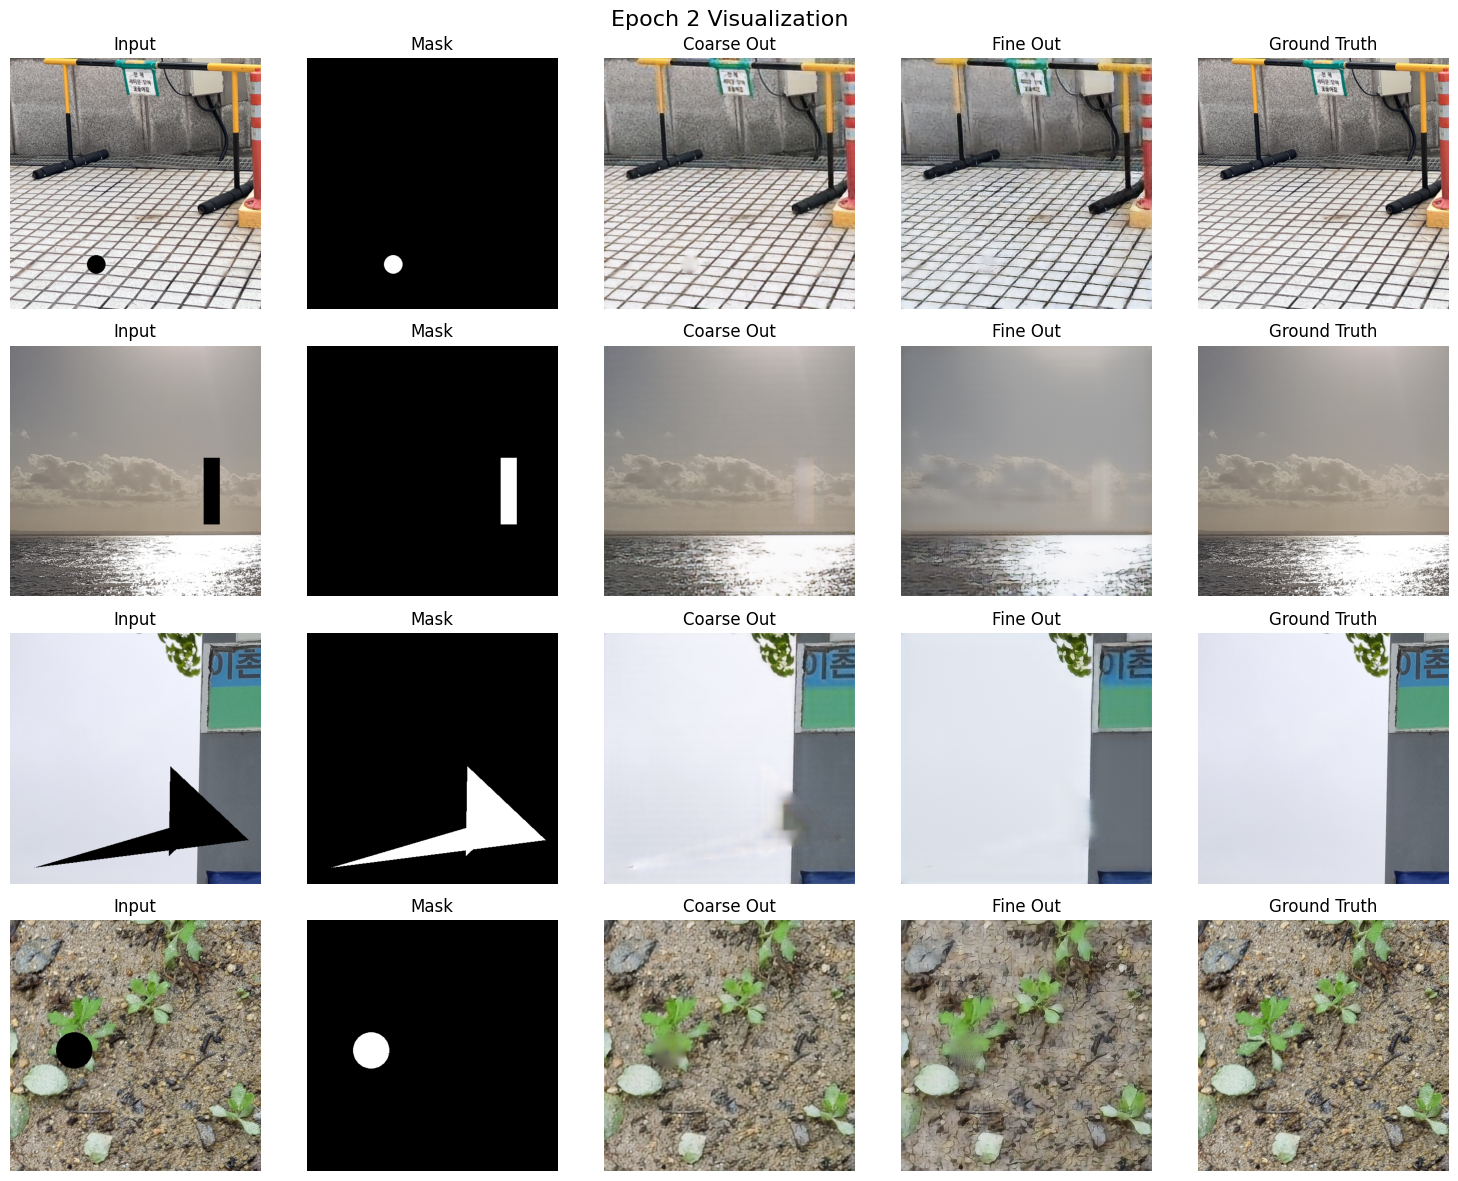

최적 모델 갱신! Validation L1 Loss: 0.0610, 모델 저장 완료.


Epoch [3/50]: 100%|██████████| 5921/5921 [1:26:17<00:00,  1.14it/s]

Epoch [3/50] - G Loss: 10.6162, D Loss: 0.5956


Validation L1 Loss: 0.0595


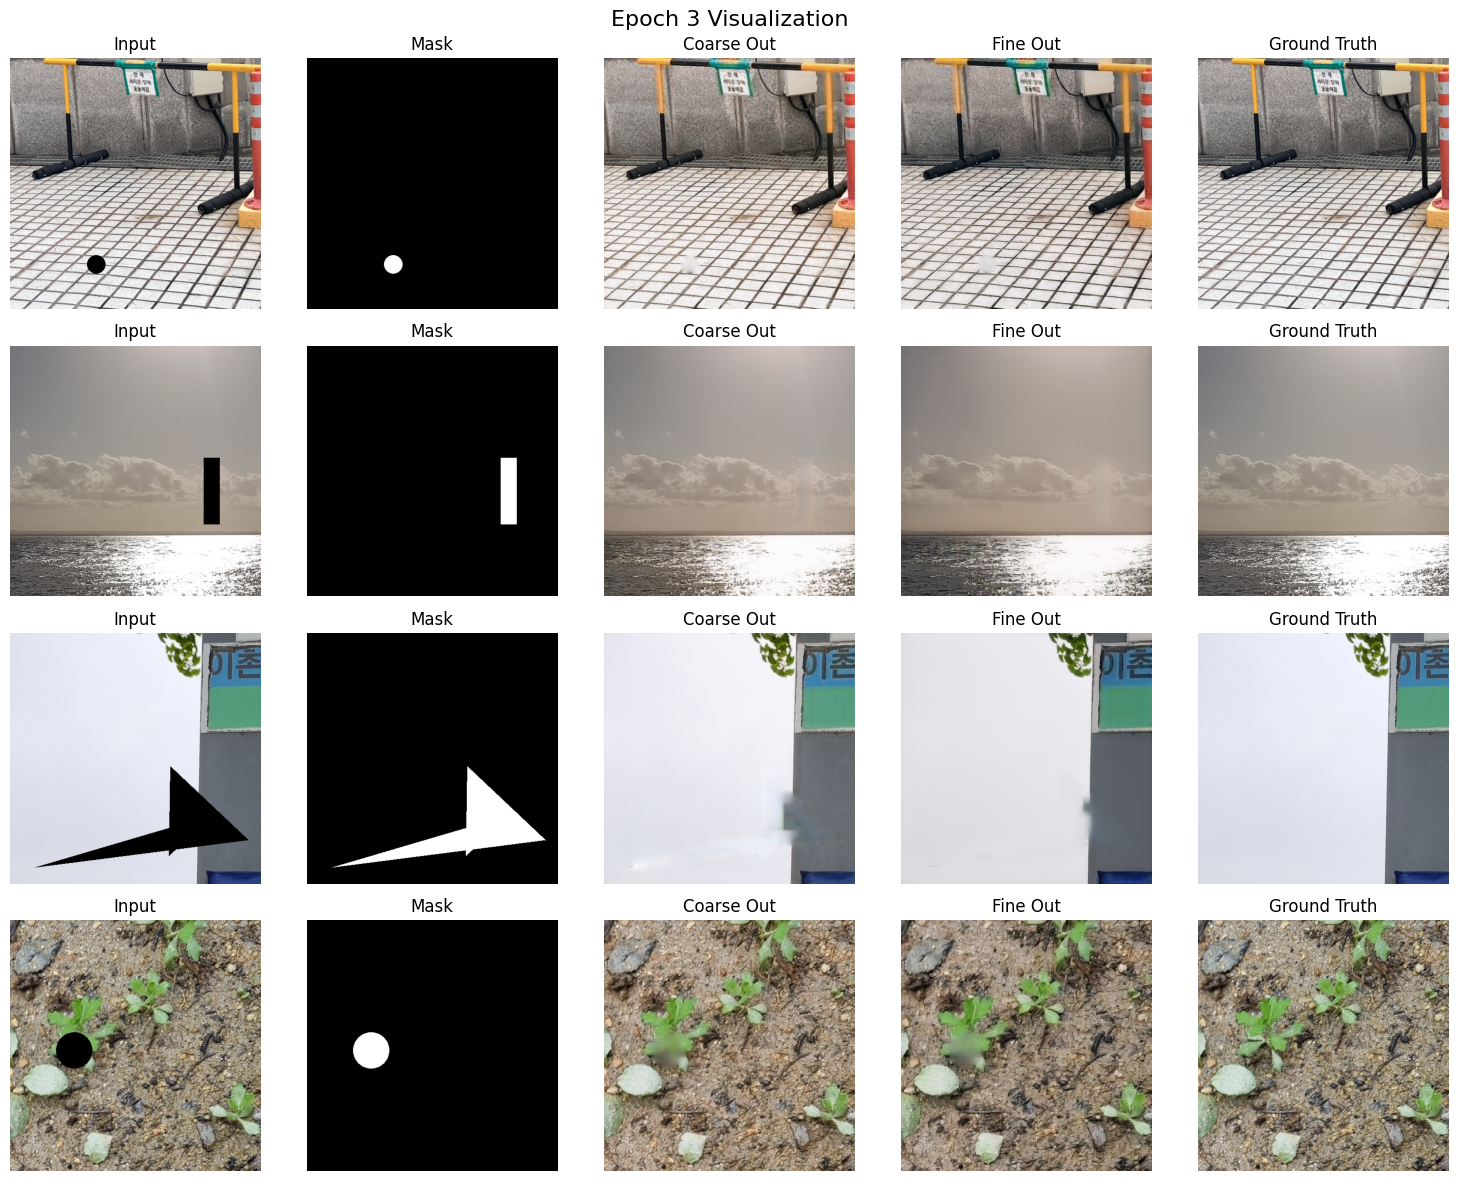

최적 모델 갱신! Validation L1 Loss: 0.0595, 모델 저장 완료.


Epoch [4/50]: 100%|██████████| 5921/5921 [1:26:13<00:00,  1.14it/s]

Epoch [4/50] - G Loss: 8.7648, D Loss: 0.6249


Validation L1 Loss: 0.0512


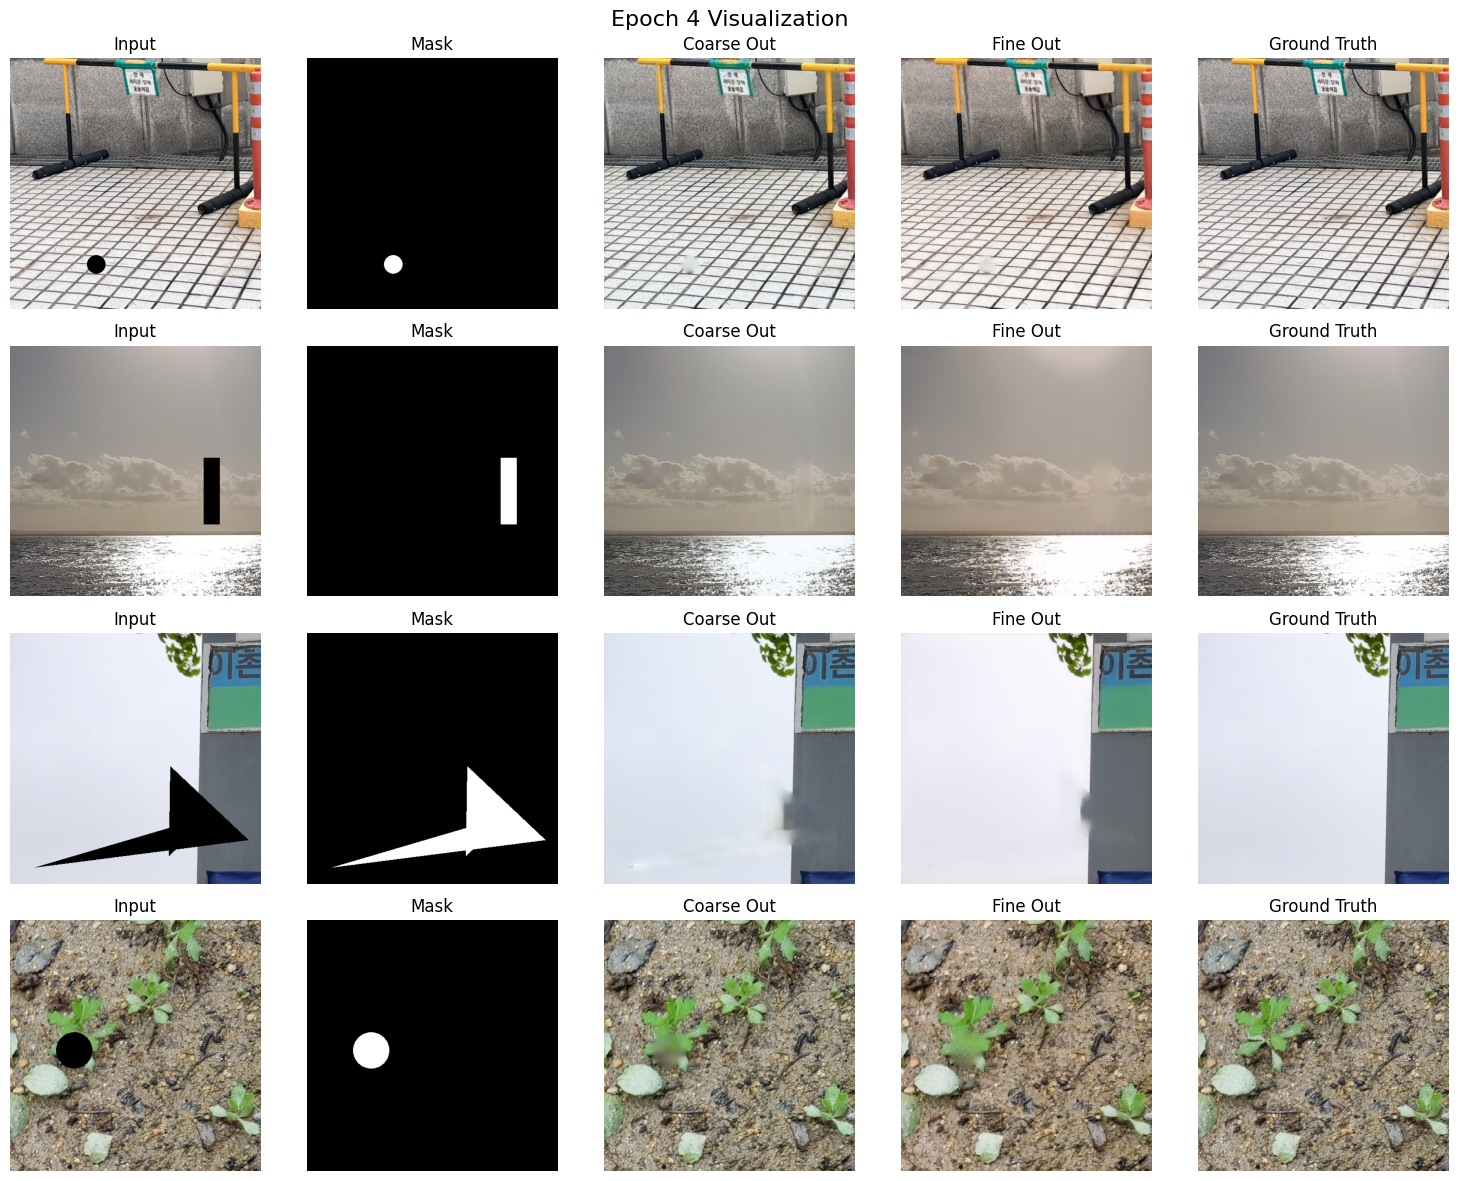

최적 모델 갱신! Validation L1 Loss: 0.0512, 모델 저장 완료.


Epoch [5/50]: 100%|██████████| 5921/5921 [1:26:16<00:00,  1.14it/s]

Epoch [5/50] - G Loss: 7.6103, D Loss: 0.6425


Validation L1 Loss: 0.0427


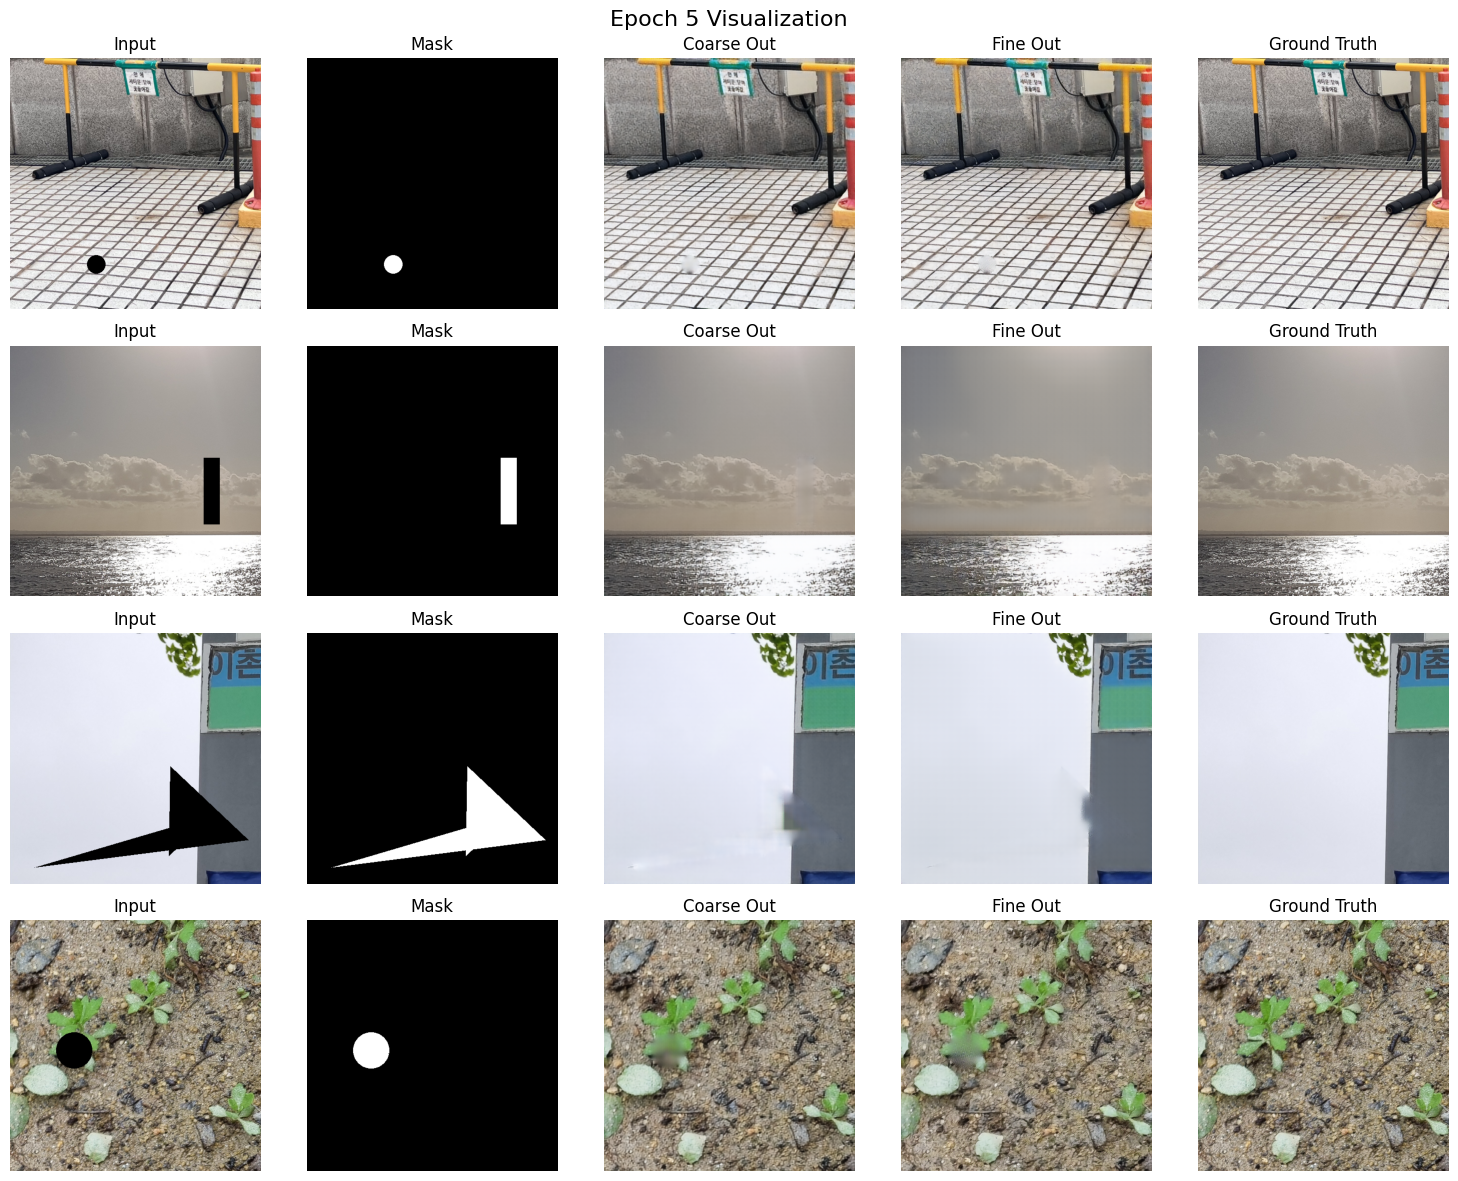

최적 모델 갱신! Validation L1 Loss: 0.0427, 모델 저장 완료.


Epoch [6/50]:  42%|████▏     | 2489/5921 [36:16<50:03,  1.14it/s]

In [ ]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torchvision.models import vgg19, VGG19_Weights

#---------------------------
# 파라미터 설정
#---------------------------
batch_size = 4
lr = 0.0002
epochs = 50
test_size = 0.2
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/damage_images/damage_images"
gt_dir = "/root/.cache/kagglehub/datasets/geon05/dataset2/versions/1/train_gt"
mask_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/output_masks/output_masks"

#---------------------------
# Perceptual Loss 정의
#---------------------------
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer_ids=[0, 5, 10, 19, 28], requires_grad=False):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        self.layers = nn.ModuleList([vgg[i] for i in layer_ids])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x, y):
        loss = 0.0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def normalize_vgg_inputs(img):
    return (img - vgg_mean) / vgg_std

#---------------------------
# Gated Convolution Layer 정의
#---------------------------
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
        super(GatedConv2d, self).__init__()
        self.feature_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_conv(x)
        m = self.mask_conv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class GatedDeconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, activation=nn.ReLU()):
        super(GatedDeconv2d, self).__init__()
        self.feature_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_deconv(x)
        m = self.mask_deconv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class ContextualAttention(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dilation=1):
        super(ContextualAttention, self).__init__()
        self.conv = nn.Conv2d(512, 512, kernel_size, stride, dilation, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B,C,H,W = x.size()
        query = x.view(B,C,-1)
        key = x.view(B,C,-1)
        value = x.view(B,C,-1)

        attn = torch.bmm(query.permute(0,2,1), key)
        attn = self.softmax(attn)
        out = torch.bmm(attn, value.permute(0,2,1))
        out = out.permute(0,2,1).view(B,C,H,W)
        out = self.conv(out)
        return out

class Stage1Generator(nn.Module):
    def __init__(self):
        super(Stage1Generator, self).__init__()
        self.encoder = nn.Sequential(
            GatedConv2d(4, 64, 4, 2, 1),
            GatedConv2d(64, 128, 4, 2, 1),
            GatedConv2d(128, 256, 4, 2, 1),
            GatedConv2d(256, 512, 4, 2, 1)
        )

        self.decoder = nn.Sequential(
            GatedDeconv2d(512, 256, 4, 2, 1),
            GatedDeconv2d(256, 128, 4, 2, 1),
            GatedDeconv2d(128, 64, 4, 2, 1),
            GatedDeconv2d(64, 64, 4, 2, 1, activation=nn.ReLU()),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x, mask):
        inp = torch.cat((x, mask), dim=1)
        feat = self.encoder(inp)
        out = self.decoder(feat)
        return out

class Stage2Generator(nn.Module):
    def __init__(self):
        super(Stage2Generator, self).__init__()
        self.encoder = nn.Sequential(
            GatedConv2d(7, 64, 4, 2, 1),   # 7채널 입력 (coarse_out(3ch)+inp(3ch)+mask(1ch))
            GatedConv2d(64, 128, 4, 2, 1),
            GatedConv2d(128, 256, 4, 2, 1),
            GatedConv2d(256, 512, 4, 2, 1)
        )
        self.contextual_attention = ContextualAttention()
        self.decoder = nn.Sequential(
            GatedDeconv2d(512, 256, 4, 2, 1),
            GatedDeconv2d(256, 128, 4, 2, 1),
            GatedDeconv2d(128, 64, 4, 2, 1),
            GatedDeconv2d(64, 64, 4, 2, 1, activation=nn.ReLU()),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, coarse_out, inp, mask):
        fin_inp = torch.cat((coarse_out, inp, mask), dim=1)
        feat = self.encoder(fin_inp)
        feat = self.contextual_attention(feat)
        out = self.decoder(feat)
        return out

class InpaintDiscriminator(nn.Module):
    def __init__(self):
        super(InpaintDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128,4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,256,4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256,1,4,1,1)
        )

    def forward(self, x):
        return self.model(x)

class InpaintDataset(Dataset):
    def __init__(self, input_paths, gt_paths, mask_paths, transform=None):
        self.input_paths = input_paths
        self.gt_paths = gt_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        inp = Image.open(self.input_paths[idx]).convert("RGB")
        gt = Image.open(self.gt_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            inp = self.transform(inp)
            gt = self.transform(gt)
            mask = self.transform(mask)

        return inp, gt, mask

input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('png','jpg','jpeg'))])
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith(('png','jpg','jpeg'))])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('png','jpg','jpeg'))])

train_input_paths, val_input_paths, train_gt_paths, val_gt_paths, train_mask_paths, val_mask_paths = train_test_split(
    input_files, gt_files, mask_files, test_size=test_size, random_state=42)

transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor()
])

train_dataset = InpaintDataset(train_input_paths, train_gt_paths, train_mask_paths, transform=transform)
val_dataset = InpaintDataset(val_input_paths, val_gt_paths, val_mask_paths, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

coarse_generator = Stage1Generator().to(device)
fine_generator = Stage2Generator().to(device)
discriminator = InpaintDiscriminator().to(device)

g_params = list(coarse_generator.parameters()) + list(fine_generator.parameters())
g_optimizer = optim.Adam(g_params, lr=lr, betas=(0.5, 0.9))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
perceptual_criterion = VGGPerceptualLoss().to(device)

save_dir = "2024_02"
os.makedirs(save_dir, exist_ok=True)

best_val_loss = float('inf')

########################################
# 이전에 학습한 모델 가중치 로드
########################################

pretrained_coarse_path = "/content/2024_01/coarse_generator_epoch4.pth"
pretrained_fine_path = "/content/2024_01/fine_generator_epoch4.pth"
pretrained_dis_path = "/content/2024_01/discriminator_epoch4.pth"

if os.path.exists(pretrained_coarse_path) and os.path.exists(pretrained_fine_path) and os.path.exists(pretrained_dis_path):
    coarse_generator.load_state_dict(torch.load(pretrained_coarse_path, map_location=device, weights_only=True))
    fine_generator.load_state_dict(torch.load(pretrained_fine_path, map_location=device, weights_only=True))
    discriminator.load_state_dict(torch.load(pretrained_dis_path, map_location=device, weights_only=True))

    print("이전 학습된 모델 가중치를 불러와 이어서 학습합니다.")
else:
    print("이전 모델 가중치를 찾지 못했습니다. 처음부터 학습을 시작합니다.")

########################################
# 학습
########################################

for epoch in range(epochs):
    coarse_generator.train()
    fine_generator.train()
    discriminator.train()
    running_g_loss = 0.0
    running_d_loss = 0.0

    for i, (inp, gt, mask) in enumerate(tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")):
        inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)

        # Coarse 단계
        coarse_out = coarse_generator(inp, mask)

        # Fine 단계
        fine_out = fine_generator(coarse_out, inp, mask)

        # Train Discriminator
        real_pred = discriminator(gt)
        fake_pred = discriminator(fine_out.detach())

        real_label = torch.ones_like(real_pred).to(device)
        fake_label = torch.zeros_like(fake_pred).to(device)

        d_loss_real = bce_loss(real_pred, real_label)
        d_loss_fake = bce_loss(fake_pred, fake_label)
        d_loss = (d_loss_real + d_loss_fake) * 0.5

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        fake_pred = discriminator(fine_out)
        real_label_g = torch.ones_like(fake_pred).to(device)
        g_adv_loss = bce_loss(fake_pred, real_label_g)

        c_l1 = l1_loss(coarse_out, gt)
        c_mse = mse_loss(coarse_out, gt)
        c_perc = perceptual_criterion(normalize_vgg_inputs(coarse_out), normalize_vgg_inputs(gt))
        c_recon = 10.0*c_l1 + 5.0*c_mse + 1.0*c_perc

        f_l1 = l1_loss(fine_out, gt)
        f_mse = mse_loss(fine_out, gt)
        f_perc = perceptual_criterion(normalize_vgg_inputs(fine_out), normalize_vgg_inputs(gt))
        f_recon = 10.0*f_l1 + 5.0*f_mse + 1.0*f_perc

        g_loss = g_adv_loss + 0.5*c_recon + f_recon

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()

    avg_g_loss = running_g_loss / len(train_dataloader)
    avg_d_loss = running_d_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    # ---------------------------
    # Validation
    # ---------------------------
    coarse_generator.eval()
    fine_generator.eval()
    val_l1 = 0.0
    with torch.no_grad():
        for inp, gt, mask in val_dataloader:
            inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)
            coarse_out = coarse_generator(inp, mask)
            fine_out = fine_generator(coarse_out, inp, mask)
            val_l1 += l1_loss(fine_out, gt).item()
    val_l1 = val_l1 / len(val_dataloader)
    print(f"Validation L1 Loss: {val_l1:.4f}")

    # ---------------------------
    # 에폭마다 시각화 (추가 부분)
    # ---------------------------
    with torch.no_grad():
        # (1) Validation dataloader에서 배치 하나 샘플 추출
        sample_inp, sample_gt, sample_mask = next(iter(val_dataloader))
        sample_inp, sample_gt, sample_mask = sample_inp.to(device), sample_gt.to(device), sample_mask.to(device)

        # (2) Generator 통과
        sample_coarse = coarse_generator(sample_inp, sample_mask)
        sample_fine = fine_generator(sample_coarse, sample_inp, sample_mask)

        # (3) Tensor -> NumPy (시각화를 위해 [N,C,H,W]->[N,H,W,C])
        sample_inp_np = sample_inp.detach().cpu().permute(0,2,3,1).numpy()
        sample_gt_np = sample_gt.detach().cpu().permute(0,2,3,1).numpy()
        sample_mask_np = sample_mask.detach().cpu().permute(0,2,3,1).numpy()
        sample_coarse_np = sample_coarse.detach().cpu().permute(0,2,3,1).numpy()
        sample_fine_np = sample_fine.detach().cpu().permute(0,2,3,1).numpy()

        # (4) 일부(batch 내 최대 4장만) 시각화
        num_show = min(4, sample_inp_np.shape[0])
        fig, axs = plt.subplots(num_show, 5, figsize=(15, 3 * num_show))
        fig.suptitle(f"Epoch {epoch+1} Visualization", fontsize=16)

        for i in range(num_show):
            # Input
            axs[i, 0].imshow(np.clip(sample_inp_np[i], 0, 1))
            axs[i, 0].set_title("Input")
            axs[i, 0].axis('off')

            # Mask (흑백)
            axs[i, 1].imshow(sample_mask_np[i].squeeze(), cmap='gray')
            axs[i, 1].set_title("Mask")
            axs[i, 1].axis('off')

            # Coarse Out
            axs[i, 2].imshow(np.clip(sample_coarse_np[i], 0, 1))
            axs[i, 2].set_title("Coarse Out")
            axs[i, 2].axis('off')

            # Fine Out
            axs[i, 3].imshow(np.clip(sample_fine_np[i], 0, 1))
            axs[i, 3].set_title("Fine Out")
            axs[i, 3].axis('off')

            # Ground Truth
            axs[i, 4].imshow(np.clip(sample_gt_np[i], 0, 1))
            axs[i, 4].set_title("Ground Truth")
            axs[i, 4].axis('off')

        plt.tight_layout()
        plt.show()
        # plt.savefig(f"{save_dir}/epoch_{epoch+1}_visual.png")  # 파일로 저장하려면 사용

    # ---------------------------
    # 모델 저장
    # ---------------------------
    torch.save(coarse_generator.state_dict(), f"{save_dir}/coarse_generator_epoch{epoch+1}.pth")
    torch.save(fine_generator.state_dict(), f"{save_dir}/fine_generator_epoch{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"{save_dir}/discriminator_epoch{epoch+1}.pth")

    # 최적 모델 갱신 체크
    if val_l1 < best_val_loss:
        best_val_loss = val_l1
        torch.save(coarse_generator.state_dict(), f"{save_dir}/best_coarse_generator_epoch{epoch+1}.pth")
        torch.save(fine_generator.state_dict(), f"{save_dir}/best_fine_generator_epoch{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"{save_dir}/best_discriminator_epoch{epoch+1}.pth")
        print(f"최적 모델 갱신! Validation L1 Loss: {val_l1:.4f}, 모델 저장 완료.")
